<a href="https://colab.research.google.com/github/harinjoshi/FindingLaneLines/blob/master/BasicLanelineDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I developed this project during my initial days of starting out with Data Science journey.This project was developed under Udacity's self driving car nanodegree.

In this project,I have developed a pipeline on a series of individual images, and later apply the result to a video stream.


Check out the video clip "raw-lines-example.mp4" to see what the output should look like after using the helper functions below.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

## Reading an image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


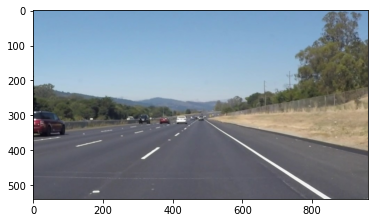

In [ ]:
image = mpimg.imread('Data/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
# For a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### Some OpenCV functions (beyond those introduced in the lesson) that might be useful are:

cv2.inRange() for color selection

cv2.fillPoly() for regions selection

cv2.line() to draw lines on an image given endpoints

cv2.addWeighted() to coadd / overlay two images cv2.cvtColor() to grayscale or change color cv2.imwrite() to output images to file

cv2.bitwise_and() to apply a mask to an image

## Helper Functions

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.Only keeps the region of the image defined by the polygon formed from `vertices`. The rest of the image is set to black. `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function can be used use as a starting point once you want to average/extrapolate the line segments you detect to map out the full extent of the lane 
    
    Think about separating line segments by their slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left line vs. the right line.  Then, you can average the position of each of the lines and extrapolate to the top and bottom of the lane.
  
    """
    extrapolate(lines,img,color,thickness)
    
    #for line in lines:
     #   for x1,y1,x2,y2 in line:
     #       cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.   
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Building a pipeline here to work on the images in "Test Directory"

In [ ]:
def extrapolate(lines,img,color,thickness):
    
    if lines is None:
        return
    if len (lines) == 0:
        return 0
    draw_right = True
    draw_left = True
    slope_threshold = 0.4
    slope_right_min=0.5
    slope_right_max=0.8
    slope_left_min=-0.8
    slope_left_max=-0.5
    max_y=0.6
    
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 9999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
        # Filter lines based on slope
        slopes.append(slope)
        new_lines.append(line)
    lines = new_lines
    
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > slope_right_min and slopes[i] < slope_right_max: #  and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] > slope_left_min and slopes[i] < slope_left_max: #and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
    
    #preparing right lines for regression         
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        right_lines_y.append(y1)
        right_lines_y.append(y2)
       
    #preparing left lines for regression
    left_lines_x = []
    left_lines_y = []

    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        left_lines_y.append(y1)
        left_lines_y.append(y2)
       
    #applyying regression on right line    
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + c
    else:
        right_m, right_b = 1, 1  # just to avoid error further calculation for calculating points of line
        draw_right = False  # case when right line not available don't draw
    
    #applyying regression on left line
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1  #just to avoid error further calculation for calculating points of line
        draw_left = False   # case when left line not available don't draw
    
    #while displaying lane marking hight of both y1 and y2 going to be same for both side of lane
    #keeping both y values as integer
    y1 = int(img.shape[0])
    y2 = int(img.shape[0] * max_y)    #taking estimated 60 % height of the image
    
    #calculating x1 and x2 for both sides using y=m*x + c
    right_x1 = int((y1 - right_b) / right_m) #converting in integer for all x values
    right_x2 = int((y2 - right_b) / right_m)
    left_x1 = int((y1 - left_b) / left_m)
    left_x2 = int((y2 - left_b) / left_m)
       
    #finally drawing lines on image 
    
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)

Build the pipeline and run your solution on all test_images. Make copies into the test_images_output directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

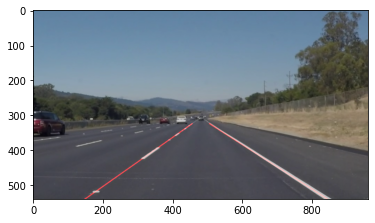

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import os
os.listdir("Data/")
def detect_lanes(image):
    #converting to grayscale in order to get a single channel 
    gray = grayscale(image)
        
    #Applyying Gaussian blur. for noise filtering
    kernel_size=3
    blur_gray = gaussian_blur(gray,kernel_size)
    
    #defining canny algorithm parameters 
    low_threshold = 50
    high_threshold = 150    
    #applying canny edge detection
    edges=canny(blur_gray,low_threshold,high_threshold)
    #plt.imshow(edges,cmap='gray' )
    
    #Region on interest selection
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    #only required part of the image is selected to find out lane lines
    masked_edges=region_of_interest(edges, vertices);
    
    #plt.imshow(masked_edges,cmap='gray' )
    
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    rho =2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 55     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 100 #minimum number of pixels making up a line
    max_line_gap = 110   # maximum gap in pixels between connectable line segments
    
    #finding lines in hough transform
    line_image = hough_lines(masked_edges,rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(line_image )
    w_image=weighted_img(line_image,image)
    plt.imshow(w_image )
    
    plt.imshow(w_image)
    


detect_lanes(image)

## Test on Videos


You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

solidWhiteRight.mp4

solidYellowLeft.mp4

If you get an error that looks like this:

NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
Follow the instructions in the error message.

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1007616/45929032 bytes (2.2%)2695168/45929032 bytes (5.9%)5079040/45929032 bytes (11.1%)8151040/45929032 bytes (17.7%)11239424/45929032 bytes (24.5%)14426112/45929032 bytes (31.4%)17686528/45929032 bytes (38.5%)20766720/45929032 bytes (45.2%)23994368/45929032 bytes (52.2%)27238400/45929032 bytes (59.3%)30302208/45929032 bytes (66.0%)33513472/45929032 bytes (73.0%)366

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    gray = grayscale(image)
        
    #Applyying Gaussian blur. for noise filtering
    kernel_size=3
    blur_gray = gaussian_blur(gray,kernel_size)
    
    #defining canny algorithm parameters 
    low_threshold = 100
    high_threshold = 200    
    #applying canny edge detection
    edges=canny(blur_gray,low_threshold,high_threshold)
    #edges = gaussian_blur(edges,kernel_size)
    
    #Region on interest selection
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    #only required part of the image is selected to find out lane lines
    masked_edges=region_of_interest(edges, vertices);
    
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    rho =1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30 #minimum number of pixels making up a line
    max_line_gap = 15   # maximum gap in pixels between connectable line segments
    
    #finding lines in hough transform
    line_image = hough_lines(masked_edges,rho, theta, threshold, min_line_len, max_line_gap)
    result=weighted_img(line_image,image)
    #plt.imshow(result)
    return result

In [ ]:
white_output = 'Data/solidWhiteRight.mp4'
## To speed up the testing process you may want to try shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## Uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("Data/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video Data/solidWhiteRight.mp4
[MoviePy] Writing video Data/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 45.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Data/solidWhiteRight.mp4 

CPU times: user 3.81 s, sys: 199 ms, total: 4.01 s
Wall time: 5.33 s


## Improve the draw_lines() function

In [ ]:
challenge_output = 'Data/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('Data/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video Data/challenge.mp4
[MoviePy] Writing video Data/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 26.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Data/challenge.mp4 

CPU times: user 7.24 s, sys: 331 ms, total: 7.57 s
Wall time: 10.5 s
